# Basics of Natural Language Processing

The basics steps:

- Pattern recognition
- Cleansing
- Tokenize
- Lemmenize
- Statitics
- Remove stop words


Let's import some python stuffs


In [1]:
import math
import re

import matplotlib.pyplot as plt

Then we need a little bit of data.

Format:
list of tuple (document, label)


In [2]:
documents = [
    ("I am happy", "happy"),
    ("I am not sad", "happy"),
    ("I am sad", "sad"),
    ("I am not happy", "sad"),
    ("John Doe is good", "happy"),
    ("John John Doe is bad", "sad"),
]

Let's define some utilities

In [3]:
def map_first(fn, list_tuples):
    return [(fn(x[0]), x[1]) for x in list_tuples]


def map_second(fn, list_tuples):
    return [(x[0], fn(x[1])) for x in list_tuples]


def map_apply(fn):
    return lambda x: list(map(fn, x))

Let's start ...


## Variables

In [4]:
n = 0

entitites = {"__person": r"\b[A-Z]\w+(\s+[A-Z]\w+)*\b"}

variables = {}


def simple_cleanser(doc):
    global n
    for k, v in entitites.items():
        completed = False
        while not completed:
            match = re.search(v, doc)
            completed = match is None
            if not completed:
                var_name, var_value = k + str(n), match.group()
                n += 1

                variables[var_name] = var_value

                s, e = match.span()
                doc = doc[:s] + var_name + doc[e:]
        return doc


var_documents = map_first(simple_cleanser, documents)
var_documents, variables

([('I am happy', 'happy'),
  ('I am not sad', 'happy'),
  ('I am sad', 'sad'),
  ('I am not happy', 'sad'),
  ('__person0 is good', 'happy'),
  ('__person1 is bad', 'sad')],
 {'__person0': 'John Doe', '__person1': 'John John Doe'})

## Cleansing


In [5]:
def simple_cleanser(doc):
    return doc.lower()


cleansed_documents = map_first(simple_cleanser, var_documents)
cleansed_documents

[('i am happy', 'happy'),
 ('i am not sad', 'happy'),
 ('i am sad', 'sad'),
 ('i am not happy', 'sad'),
 ('__person0 is good', 'happy'),
 ('__person1 is bad', 'sad')]

## Tokenize


In [6]:
def simple_tokenizer(doc):
    return doc.split(" ")


tokenized_documents = map_first(simple_tokenizer, cleansed_documents)
tokenized_documents

[(['i', 'am', 'happy'], 'happy'),
 (['i', 'am', 'not', 'sad'], 'happy'),
 (['i', 'am', 'sad'], 'sad'),
 (['i', 'am', 'not', 'happy'], 'sad'),
 (['__person0', 'is', 'good'], 'happy'),
 (['__person1', 'is', 'bad'], 'sad')]

## Lemmenize


In [7]:
lexicon = {
    "be": r"be|am|are|is",
    "happy": r"happ(y|iest)",
    "sad": r"sad(est)?",
}


def simple_lemmenizer(token):
    return next(filter(lambda x: re.search(lexicon[x], token) is not None, lexicon), token)


lemmenized_documents = map_first(map_apply(simple_lemmenizer), tokenized_documents)
lemmenized_documents

[(['i', 'be', 'happy'], 'happy'),
 (['i', 'be', 'not', 'sad'], 'happy'),
 (['i', 'be', 'sad'], 'sad'),
 (['i', 'be', 'not', 'happy'], 'sad'),
 (['__person0', 'be', 'good'], 'happy'),
 (['__person1', 'be', 'bad'], 'sad')]

## Statistics

In [8]:
vocabulary = sorted({token for tokens, _ in lemmenized_documents for token in tokens})
vocabulary

['__person0', '__person1', 'bad', 'be', 'good', 'happy', 'i', 'not', 'sad']

Compute term frequency for each document (tf)

In [9]:
def term_frequency_in_doc(tokens):
    sum_t = len(tokens)
    t_f = [(token, 1) for token in tokens]
    return {word: sum([f for t, f in t_f if t == word]) / sum_t for word in vocabulary}


term_frequencies = [term_frequency_in_doc(tokens) for tokens, _ in lemmenized_documents]
term_frequencies

[{'__person0': 0.0,
  '__person1': 0.0,
  'bad': 0.0,
  'be': 0.3333333333333333,
  'good': 0.0,
  'happy': 0.3333333333333333,
  'i': 0.3333333333333333,
  'not': 0.0,
  'sad': 0.0},
 {'__person0': 0.0,
  '__person1': 0.0,
  'bad': 0.0,
  'be': 0.25,
  'good': 0.0,
  'happy': 0.0,
  'i': 0.25,
  'not': 0.25,
  'sad': 0.25},
 {'__person0': 0.0,
  '__person1': 0.0,
  'bad': 0.0,
  'be': 0.3333333333333333,
  'good': 0.0,
  'happy': 0.0,
  'i': 0.3333333333333333,
  'not': 0.0,
  'sad': 0.3333333333333333},
 {'__person0': 0.0,
  '__person1': 0.0,
  'bad': 0.0,
  'be': 0.25,
  'good': 0.0,
  'happy': 0.25,
  'i': 0.25,
  'not': 0.25,
  'sad': 0.0},
 {'__person0': 0.3333333333333333,
  '__person1': 0.0,
  'bad': 0.0,
  'be': 0.3333333333333333,
  'good': 0.3333333333333333,
  'happy': 0.0,
  'i': 0.0,
  'not': 0.0,
  'sad': 0.0},
 {'__person0': 0.0,
  '__person1': 0.3333333333333333,
  'bad': 0.3333333333333333,
  'be': 0.3333333333333333,
  'good': 0.0,
  'happy': 0.0,
  'i': 0.0,
  'not'

Compute inverse document frequency (idf)


In [10]:
def inverse_document_frequency(word):
    sum_d = len(lemmenized_documents)
    t_f = [(word, 1 if word in tokens else 0) for word in vocabulary for tokens, _ in lemmenized_documents]
    n_t = sum([f for t, f in t_f if t == word])
    return -math.log(n_t / sum_d)


inverse_document_frequencies = {word: inverse_document_frequency(word) for word in vocabulary}
inverse_document_frequencies

{'__person0': 1.791759469228055,
 '__person1': 1.791759469228055,
 'bad': 1.791759469228055,
 'be': -0.0,
 'good': 1.791759469228055,
 'happy': 1.0986122886681098,
 'i': 0.40546510810816444,
 'not': 1.0986122886681098,
 'sad': 1.0986122886681098}

Let's put all together

In [11]:
def tf_idf(doc, token):
    return term_frequencies[doc][token] * inverse_document_frequencies[token]


tf_idfs = [
    ([(token, tf_idf(doc, token)) for token in tokens], label)
    for doc, (tokens, label) in enumerate(lemmenized_documents)
]
tf_idfs

[([('i', 0.1351550360360548), ('be', -0.0), ('happy', 0.3662040962227032)],
  'happy'),
 ([('i', 0.10136627702704111),
   ('be', -0.0),
   ('not', 0.27465307216702745),
   ('sad', 0.27465307216702745)],
  'happy'),
 ([('i', 0.1351550360360548), ('be', -0.0), ('sad', 0.3662040962227032)],
  'sad'),
 ([('i', 0.10136627702704111),
   ('be', -0.0),
   ('not', 0.27465307216702745),
   ('happy', 0.27465307216702745)],
  'sad'),
 ([('__person0', 0.5972531564093516),
   ('be', -0.0),
   ('good', 0.5972531564093516)],
  'happy'),
 ([('__person1', 0.5972531564093516),
   ('be', -0.0),
   ('bad', 0.5972531564093516)],
  'sad')]

## Remove stop words

In [12]:
final_documents = [([token for token, tf_idf in tokens if tf_idf > 0], label) for tokens, label in tf_idfs]
final_documents

[(['i', 'happy'], 'happy'),
 (['i', 'not', 'sad'], 'happy'),
 (['i', 'sad'], 'sad'),
 (['i', 'not', 'happy'], 'sad'),
 (['__person0', 'good'], 'happy'),
 (['__person1', 'bad'], 'sad')]

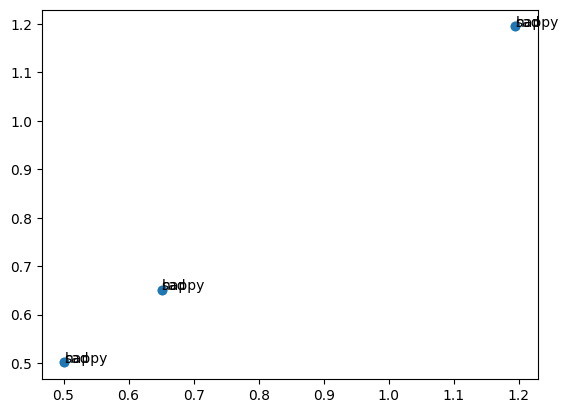

In [14]:
x = [sum([tf_idf for _, tf_idf in tokens if tf_idf > 0]) for tokens, _ in tf_idfs]
y = [sum([tf_idf for _, tf_idf in tokens if tf_idf > 0]) for tokens, _ in tf_idfs]
n = [label for _, label in tf_idfs]

plt.scatter(x, y)
for x_, y_, n_ in zip(x, y, n, strict=False):
    plt.annotate(n_, (x_, y_))